In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from neo import io
import quantities as pq

mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [193]:
# Import the list of files to analyse

ramps_df = pd.read_excel('C://Users//cdixon//Documents//DataSynaptopathies//20180410_AMPA_RampDetails.xlsx')
ramps_df.dropna(how='all', inplace=True)
summary_df = pd.read_excel('C://Users//cdixon//Documents//DataSynaptopathies//2017Electrophysiology/825RigBackup/GluR2_KA_summary060518.xlsx',
                              sheetname='Gria1')
summary_df['Record'] = summary_df['Record'].astype(str)
summary_df['Date'] = summary_df['Date'].astype(str)

def make_filenames(summary=summary_df, ramps_df=ramps_df):
    summary_df['File'] = 'blank'
    for row in range(0, len(summary_df)):
        summary_df['File'][row] = summary_df['Date'][row] + '_' + summary_df['Record'][row][:3]

make_filenames()
ramps_df = pd.merge(ramps_df, summary_df[['Mutant', 'File']], how='inner', on='File')
# ramps_df.sort_values('Mutant', inplace=True) # Do this for graphing
ramps_df.reset_index(drop=True, inplace=True)

ramps_df['Analysis_start']=ramps_df['Analysis_start'].replace(0, 1) #functions require -1s before start

# Note: ramps threshold here refers to classifying a ramp as control or drug, not identifying ramps

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [171]:

ramps_df['Mutant'].value_counts()
ramps_df.shape

(78, 8)

In [162]:

class Cell:
    '''Loads the data for one cell, as defined in the summary dataframe'''
    def __init__(self, filepath, df, row):
        start_ms = int(df['Analysis_start'][row]-1)*1000
        end_ms = int(df['Analysis_end'][row]+2)*1000
        r = io.WinEdrIO(filename=filepath)
        seg = r.read_segment(lazy=False, cascade=True,)
        I = seg.analogsignals[0]
        self.I = I[start_ms:end_ms]         
        if end_ms > len(I):  #keep in mind that I and self.I are different
            end_ms = len(I)
        print('total= ' , len(I), 'start=', start_ms, 'end=', end_ms)
        time = seg.analogsignals[0].times # warning: this can extend beyond the length of the recording;
        # can lead to len(t) > len(I)
        self.time = time[0:(end_ms - start_ms)] # In case the I is shorter than specified; need to keep t the same

        
# This is more flexible not being a class: just use a function and return 2 values (I and t).
# That allows the inputs to just be passed independent of the class (which requires you to call the df)


def read_currentTime_batch(filepath, df, row):
    '''Returns time and current from WinEDR file, trimming the file according to df. Units are extracted; use .values if necessary'''
    start_ms = int(df['Analysis_start'][row]-1)*1000
    end_ms = int(df['Analysis_end'][row]+2)*1000
    r = io.WinEdrIO(filename=filepath)
    seg = r.read_segment(lazy=False, cascade=True,)
    I = seg.analogsignals[0]
    I = I[start_ms:end_ms] 
    print('total= ' , len(I), 'start=', start_ms, 'end=', end_ms)
    if (end_ms - start_ms) > len(I):
        end_ms = len(I)
    time = seg.analogsignals[0].times # warning: this can extend beyond the length of the recording;
    # can lead to len(t) > len(I)
    time = time[0:(end_ms - start_ms)] # This forces the len(I) and len(t) to be the same
    return (I, time)
    
    
def read_currentTime_single_file(filepath):
    '''reads signal for the whole file; does not require start and end time from dataFrame'''
    r = io.WinEdrIO(filename=filepath)
    seg = r.read_segment(lazy=False, cascade=True,)
    I = seg.analogsignals[0]
    time = seg.analogsignals[0].times
    return (I, time)




In [175]:
'''
Attempted to refactor to use the single cell processing function
Current fail: on 180405_003, doesn't identify drug ramps

'''


def Process_cells_batch (df=ramps_df, jump_threshold=50):
    df['RI'] = ''
    for row in range(0, len(df)): #len(df)
        print('Processing row ', row)

        process_cells_df(df, row)
        
        df['RI'][row] = RI
        
        print(filename, 'processed')
    df.to_excel('ramps_results.xlsx')

# Process_cells_batch (df=ramps_df, jump_threshold=50)

Processing 180405_003
total=  66000 start= 24000 end= 90000
Without duplicates:  [3637, 5437, 7883, 9683, 11938, 13738, 21045, 22845, 24732, 26532, 28595, 30395, 36964, 38764, 41144, 42944, 45007, 46807, 52374, 54174, 56183, 57983, 60110, 61910]
robust = [3637, 7883, 11938, 21045, 24732, 28595, 36964, 41144, 45007, 52374, 56183, 60110]
-500.0
control [3637, 7883, 11938, 36964, 41144, 45007]


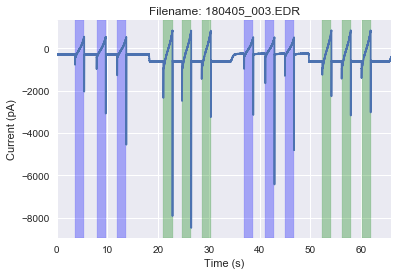

-500.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


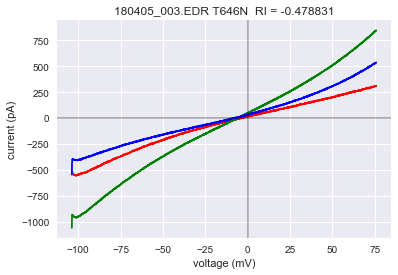

RI =  -0.478831
finished processing 180405_003.EDR


(AnalogSignal with 1 channels of length 66000; units pA; datatype float32 
 name: 'Im0'
 annotations: {'channel_index': 0}
 sampling rate: 1000.0 Hz
 time: 24.0 s to 90.0 s,
 array([  0.00000000e+00,   1.00000000e-03,   2.00000000e-03, ...,
          6.59970000e+01,   6.59980000e+01,   6.59990000e+01]) * s)

In [191]:

def process_cell(I, time, drug_threshold, filename, mutant = ' '):
    '''Suitable for individual or batch processing of ramp files
    Mutant can be left blank or filled in from the df if batch processing
    Packages functions for: finding ramps, classifying, subtracting, clculating RI,
    graphing for inspection of ramp classification, graph of ramps and outputting ramp data as csv'''
    
    jumps = find_jumps(data=I) #allows default jump threshold to default to 50. Not the same as drug threshold
    ramp_starts = ramp_start_robust(jumps)
    print('robust =', ramp_starts)
    
    c_ramp_starts, d_ramp_starts = control_or_drug(I, drug_threshold, ramp_starts) 
    print ('control', c_ramp_starts)
 
    plot_trace(time, I, filename, c_ramp_starts, d_ramp_starts)
    subtracted = subtracted_ramp(I, ramp_starts, drug_threshold)
    RI, pos, neg = rectification(subtracted)
    
    # this needs to be fed data from frame when used for batch
    graph_final_ramps(I, filename, mutant, subtracted, c_ramp_starts, d_ramp_starts, RI)#Is this really graphing new data???
    save_ramp_data(filename, I, time, subtracted, c_ramp_starts, d_ramp_starts)
    # df['RI'][row] = RI
    # Need to add return values?
    # Save c_ramp_starts, d_ramp_starts
    
    print('RI = ', RI)
    return subtracted, c_ramp_starts, d_ramp_starts, RI
    

#filepath = '180607_007.EDR'  # currently in this folder, full path not needed
#filename = '180607_007'
#drug_threshold = ramps_df['ramp threshold'][ramps_df['File'] == filename].values[0]

#I, time = read_currentTime_single_file(filepath)
#subtracted, c_ramp_starts, d_ramp_starts, RI = process_cell(I, time, drug_threshold, filename)


def process_cells_df(df, row):
    '''to proccess a single cell, but pulling from the dataframe'''
    filepath = df['File'][row]
    print('Processing', filepath)
    filename = df['File'][row] + '.EDR'
    I, time = read_currentTime_batch(filename, df, row)
    drug_threshold = df['ramp threshold'][row]
    process_cell(I, time, drug_threshold, filename, df['Mutant'][row])
    print('finished processing', filename)
    return I, time


process_cells_df(ramps_df, 2)

    

In [134]:

    
    
def save_ramp_data(filename, I, time, subtracted, c_ramp_starts, d_ramp_starts):
    # dump the 3 different ramps into a CSV and save it
    # Need to use the ramp starts to pull out the full value of the ramp
    
    sub = pd.DataFrame(subtracted, columns=['Subtracted'])
    drug = pd.DataFrame(average_ramps(I, d_ramp_starts), columns=['Drug'])
    con = pd.DataFrame(average_ramps(I, c_ramp_starts), columns=['Control'])
    rampsSummary = pd.concat([sub, drug, con], axis=1)
    save_as = filename + 'RampSummary.csv'
    rampsSummary.to_csv(save_as)
    return rampsSummary

#save_ramp_data(filename, I, time, subtracted, c_ramp_starts, d_ramp_starts)


Processing row  69
total=  125748 start= 39000 end= 94000
Without duplicates:  [2613, 4413, 5921, 7721, 9606, 11406, 14259, 15372, 16983, 17218, 18534, 18885, 19018, 19351, 19791, 21082, 22882, 24825, 26407, 26625, 38812, 40301, 42101, 44051, 45851, 48106, 49906, 53620, 54315, 54419]
robust = [2613, 5921, 9606, 17218, 21082, 24825, 40301, 44051, 48106]
-1000.0
time len= 55000 I len= 55000


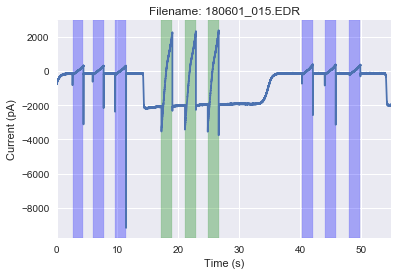

-1000.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


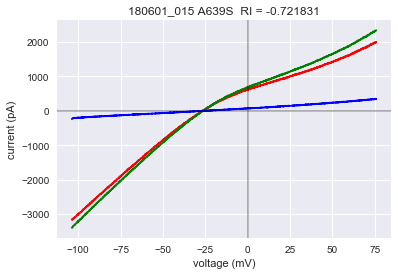

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


180601_015.EDR processed
Processing row  70
total=  147704 start= 24000 end= 102000
Without duplicates:  [1015, 2814, 4945, 6745, 10129, 11929, 19736, 21536, 23230, 25030, 26067, 27102, 28902, 31699, 32443, 36959, 38759, 40640, 42440, 43945, 45745, 53809, 55609, 57613, 59413, 61482, 63282]
robust = [4945, 10129, 19736, 23230, 27102, 36959, 40640, 43945, 53809, 57613, 61482]
-1000.0
time len= 78000 I len= 78000


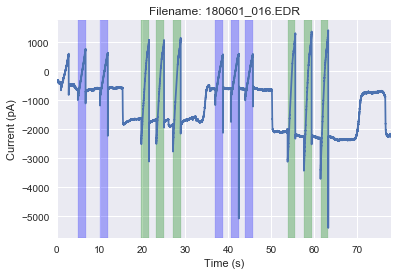

-1000.0


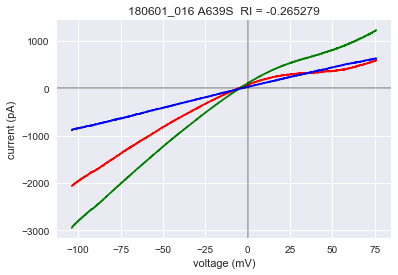

180601_016.EDR processed
Processing row  71
total=  197604 start= 79000 end= 182000
Without duplicates:  [2500, 8293, 10093, 11908, 13708, 15590, 17390, 23515, 25315, 34809, 36609, 38803, 40603, 47600, 49400, 51343, 53143, 55087, 56887, 67127, 70128, 71928, 73746, 75546, 77682, 79482, 84542, 86342, 88224, 90024, 91967, 93767, 98932, 102252, 102256]
robust = [8293, 11908, 15590, 23515, 34809, 38803, 47600, 51343, 55087, 70128, 73746, 77682, 84542, 88224, 91967]
-1000.0
time len= 103000 I len= 103000


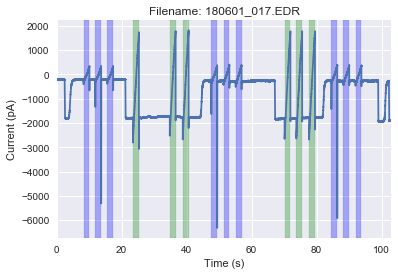

-1000.0


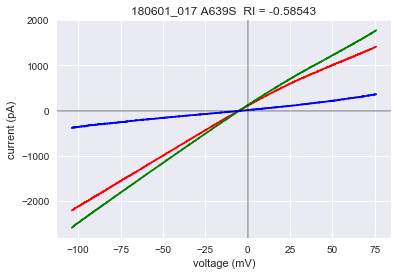

180601_017.EDR processed
Processing row  72
total=  169660 start= 27000 end= 107000
Without duplicates:  [3080, 4880, 7127, 8927, 11061, 12861, 16315, 22854, 24654, 26656, 28456, 30400, 32200, 39760, 41560, 44072, 45872, 48936, 50736, 55276, 58174, 59974, 62410, 64210, 68650, 70450, 78642]
robust = [3080, 7127, 11061, 22854, 26656, 30400, 39760, 44072, 48936, 58174, 62410, 68650]
-1500.0
time len= 80000 I len= 80000


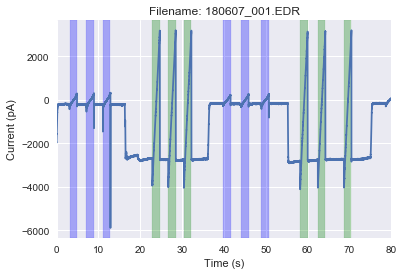

-1500.0


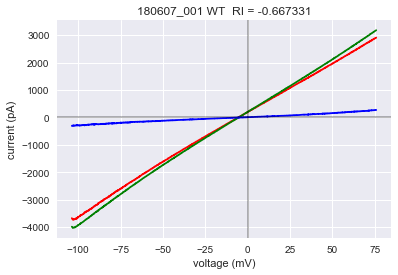

180607_001.EDR processed
Processing row  73
total=  105788 start= 27000 end= 92000
Without duplicates:  [2324, 4124, 5939, 7739, 9750, 11550, 16983, 18783, 20670, 22470, 24474, 26274, 31712, 33512, 35332, 37132, 38884, 40684, 44127, 45927, 51621, 53421, 55989, 57789, 59607, 61407, 64343]
robust = [2324, 5939, 9750, 16983, 20670, 24474, 31712, 35332, 38884, 44127, 51621, 55989, 59607]
-1000.0
time len= 65000 I len= 65000


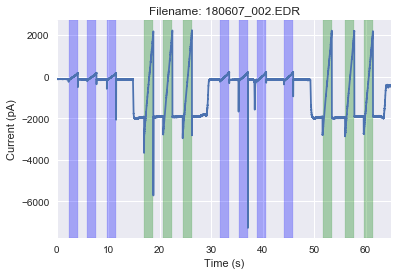

-1000.0


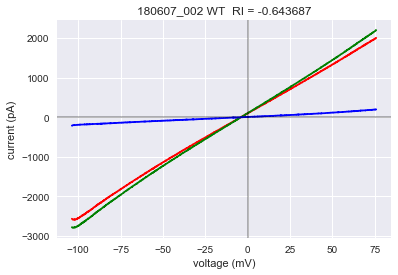

180607_002.EDR processed
Processing row  74
total=  135728 start= 24000 end= 115000
Without duplicates:  [3820, 5620, 7382, 7519, 9182, 11065, 12865, 15787, 18364, 20164, 22602, 24402, 31465, 33265, 39075, 40875, 46627, 48427, 50814, 52614, 57674, 59474, 60498, 62928, 65348, 67148, 68591, 70391, 72272, 74072, 77952, 79514, 81314, 81801, 83005, 84805, 85694, 86489, 88305]
robust = [3820, 7382, 11065, 18364, 22602, 31465, 39075, 46627, 50814, 57674, 65348, 68591, 72272, 79514, 83005]
-2000.0
time len= 91000 I len= 91000


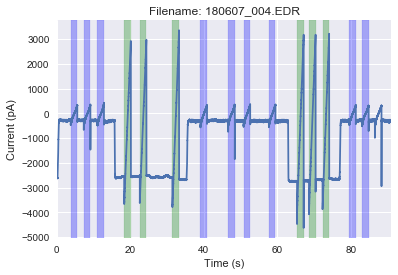

-2000.0


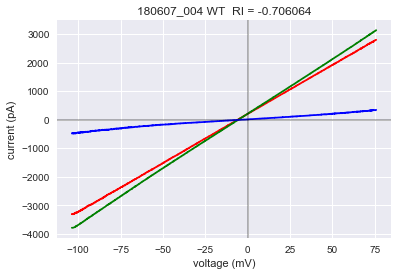

180607_004.EDR processed
Processing row  75
total=  105788 start= 9000 end= 42000
Without duplicates:  [3971, 5771, 7657, 9457, 11646, 13446, 18014, 19814, 21383, 23183, 25937, 27737]
robust = [3971, 7657, 11646, 18014, 21383, 25937]
-500.0
time len= 33000 I len= 33000


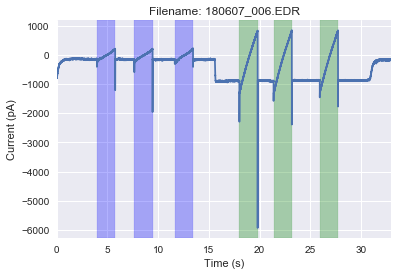

-500.0


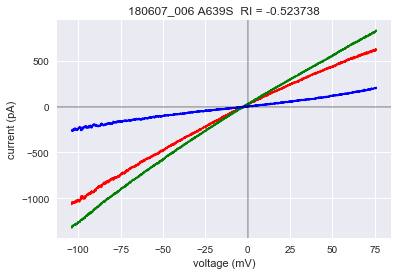

180607_006.EDR processed
Processing row  76
total=  129740 start= 0 end= 50000
Without duplicates:  [3425, 5225, 7730, 9530, 11285, 13085, 21025, 22825, 24186, 25080, 26880, 28947, 30747, 36440, 38240, 40553, 42353, 44359, 46159]
robust = [3425, 7730, 11285, 21025, 25080, 28947, 36440, 40553, 44359]
-1000.0
time len= 50000 I len= 50000


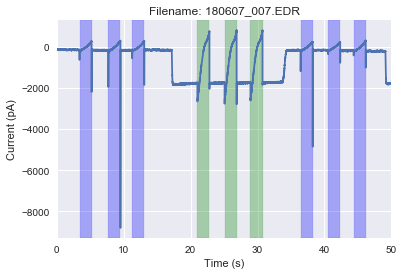

-1000.0


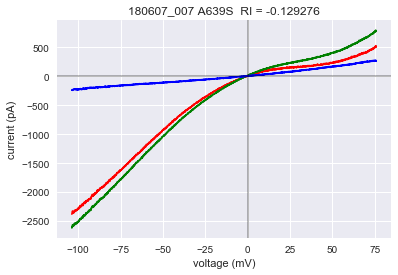

180607_007.EDR processed
Processing row  77
total=  105788 start= 19000 end= 69000
Without duplicates:  [53, 965, 2859, 3508, 3690, 4554, 4996, 5514, 7314, 7862, 8911, 10710, 11311, 11558, 12245, 12566, 13253, 13417, 15053, 17187, 18987, 21436, 22401, 22703, 23226, 27479, 29279, 30803, 32004, 32527, 34531, 36331, 38400, 39221, 39523, 41323, 41548, 41687, 43627, 44017, 44340, 45274, 46127, 46448, 46760, 46980, 47331, 47576, 47711, 47954, 48205, 48409, 48535, 48808, 48966, 49032]
robust = [5514, 13253, 17187, 27479, 34531, 39523]
-1000.0
time len= 50000 I len= 50000


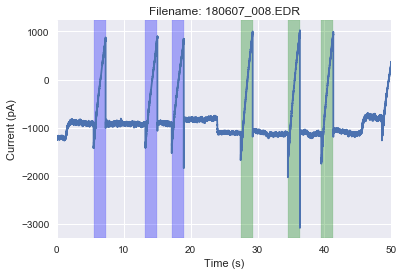

-1000.0


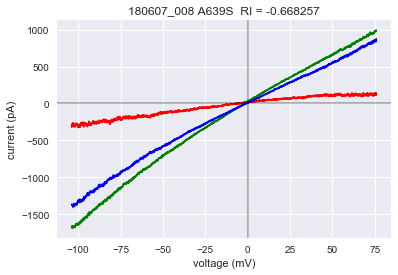

180607_008.EDR processed


In [194]:
# This needs refactoring
# Break into Process Cell independent of Batch process
# Also need to export subtracted ramp values as a csv for each cell

def batch_process(df=ramps_df, jump_threshold=50):
    df['RI'] = ''
    df['40mV I'] = ''
    df['-70mV I'] = ''
    for row in range(69, len(df)): #len(df)
        print('Processing row ', row)
        filename = df['File'][row] + '.EDR'
        filepath = 'C:\\Users\\cdixon\\Documents\\DataSynaptopathies\\2018\\Glu\\' + filename
        
        cell = Cell(filepath, df, row)
        
        jumps = find_jumps(data=cell.I, threshold=jump_threshold)
        ramp_starts = ramp_start_robust(jumps)
        print('robust =', ramp_starts)
        drug_threshold = df['ramp threshold'][row]
        c_ramp_starts, d_ramp_starts = control_or_drug(cell.I, drug_threshold, ramp_starts) #this is not changing for the iterator
        print ('time len=', len(cell.time), 'I len=', len(cell.I))
        plot_trace(cell.time, cell.I, filename, c_ramp_starts, d_ramp_starts)
        subtracted = subtracted_ramp(cell.I, ramp_starts, drug_threshold)
        RI, pos, neg = rectification(subtracted) # 
        graph_final_ramps(cell.I, df['File'][row], df['Mutant'][row], subtracted, c_ramp_starts, d_ramp_starts, RI)#Is this really graphing new data???
        df['RI'][row] = RI
        df['40mV I'][row] = pos
        df['-70mV I'][row] = neg
        save_ramp_data(filename, cell.I, cell.time, subtracted, c_ramp_starts, d_ramp_starts)
        print(filename, 'processed')
    df.to_excel('ramps_results.xlsx')

batch_process()

# Change the graph so that it still saves, but also outputs to a plt matrix (len(files)) then saves that as pdf.
# Make the data reader slice based on the specification file
#robust segment finder sometimes finds 2 overlapping segments. Need to skip more data points?

## Plotting data for visual inspection
User must choose threshold for control and drug periods and confirm appropriate data period.

After cutting out ramps, visually check that ramps are correctly identified, classified and averaged

In [21]:
#plot data
def plot_trace(time, I, filename, c_ramp_starts, d_ramp_starts):
    '''Plots the entire file by default.
    Ramps are highlighted if the ramp identification functions have already been run'''
    try:
        plt.plot(time, I)
    except ValueError:
        print ("ValueError while plotting")
        pass
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pA)')
    #plt.ylim(yscale) # Need to add a tuple to input
    plt.xlim(0, len(time)/1000)
    plt.title('Filename: %s' %filename)
    try:
        highlight_ramps(c_ramp_starts, color = 'b')
        highlight_ramps(d_ramp_starts, color = 'g')
    except NameError:
        pass
    return plt.show()

#Consider writing a function to identify the max and min in a sensible way? Median of the points either end of ramps?

# Remove the exceptions from the main function and add them in here

In [46]:

def find_jumps(data, threshold=50):
    '''returns a list of timepoints at which a large neg jump (amplitude defined by threshold) occured across 1ms
    Threshold needs to be a positive number, even though it is a negative jump'''
    jumps = []
    for point in range(0, len(data)-2):
        if int(data[point]) > (int(data[point+1])+threshold):
            jumps.append(point)
    # print('Found these jumps: ', jumps)
    return jumps


def ramp_start(jumps):
    '''Identify adjacent pairs of start and end coordinates for ramps of 1800ms duration
    Requires points exactly 1800ms apart'''
    x = 0
    ramps = []
    while x < len(jumps)-1:
        if jumps[x]+1800 == jumps[x+1]:
            ramps.append(jumps[x])
        x = x+1
    return(ramps)


def highlight_ramps(ramp_starts, color = 'red'):
    '''Called in graph function to give visual feedback on where the ramps are identified'''
    for r in ramp_starts:
        plt.axvspan(r/1000, (r/1000)+1.8, color = color, alpha = 0.3)


In [50]:
###
test_jumps1 = [1000, 1001, 1010, 2800, 2801, 3000, 3100, 3300, 4800]
# Test that duplicates are removed
# Should remove any value that is within 100ms of it's predecessor
# Should catch multiple close values
    
def remove_duplicate_ramps(jumps):
    '''remove adjacent jumps that are too close together to be real'''
    x = 0
    remove = []
    while x < len(jumps)-1:
        for y in range(1, (len(jumps)-x -1)):
            if jumps[x+y] < jumps[x]+100:
                remove.append(jumps[x+y])
        x = x+1
    new_jumps = []
    for x in jumps:
        if x not in remove:
            new_jumps.append(x)
    print('Without duplicates: ', new_jumps)
    return(new_jumps)

remove_duplicate_ramps(test_jumps1)

Without duplicates:  [1000, 2800, 3000, 3100, 3300, 4800]


[1000, 2800, 3000, 3100, 3300, 4800]

In [51]:
   


test_jumps2 = [1000, 2800, 3000, 3300, 4800]
# test to ensure ramps are being found and spurious values ignored
# correct return:
# [1000, 3000]
# test_jumps1 will return the same

def ramp_start_robust(jumps):
    '''Identify adjacent pairs of start and end coordinates for ramps of 1800ms duration
    Check each additional jump until run out of jumps or ramp is found'''
    jumps = remove_duplicate_ramps(jumps)
    x = 0
    ramps = []
    while x < len(jumps)-1:
        for y in range(1, (len(jumps)-x)):
            if jumps[x]+1800 == jumps[x+y]:
                ramps.append(jumps[x])
                break #Having found the end of the ramp, move to next x
            elif jumps[x]+1800 < jumps[x+y]:
                break #This x doesn't have a partner, so try the next x
            else:
                continue #May still have a partner, so keep trying more y
        x = x+1
    return(ramps)

ramp_start_robust(test_jumps1)

Without duplicates:  [1000, 2800, 3000, 3100, 3300, 4800]


[1000, 3000]

In [189]:

def control_or_drug(I, drug_threshold, ramp_starts):
    '''Pass in data as I'''
    control_ramp_starts = []
    drug_ramp_starts = []
    print(drug_threshold)
    for r in ramp_starts:
        base = I[r-20].magnitude #use the first 20ms before the ramp for the baseline. Not an average
        base = base[0]
        if base > drug_threshold:
            control_ramp_starts.append(r)
        else:
            drug_ramp_starts.append(r)
    return control_ramp_starts, drug_ramp_starts


def average_ramps(I, ramp_starts):
    '''pass in raw data as I and either drug or control ramp_starts list; will return average of those'''
    #Makes the first array before looping over the others that need averaging
    x = 1
    r = ramp_starts[0]
    av_ramp = I[r-1000:r+2800].magnitude
    for r in ramp_starts[1:]:
        #select I from r-1000 to r+2800 to catch the whole ramp
        seg = I[r-1000:r+2800].magnitude
        av_ramp = av_ramp + seg
        x = x+1
    return(av_ramp/x)


def subtracted_ramp(I, ramp_starts, drug_threshold):
    '''sorts ramps into drug category based on threshold then averages'''
    try:
        c_ramp_starts, d_ramp_starts = control_or_drug(I, drug_threshold, ramp_starts)
        subtracted = average_ramps(I, d_ramp_starts)-average_ramps(I, c_ramp_starts) 
    except IndexError:
        print ('Index error in ramps')
        subtracted = 'NaN'
    return subtracted


def graph_final_ramps(I, recordname, mutant, subtracted, c_ramp_starts, d_ramp_starts, RI):
    '''Saves and outputs plot of control drug and subtracted ramps'''
    mV_ms = 180/1800   # gradient of the ramp protocol that was used in the recording
    x_ms = np.array(range(0,1800))
    x_mV = (x_ms*mV_ms)-104   #-100 because the ramp started at -100, then also -4 to correct for LJP
    fig, ax = plt.subplots()
    plt.plot(x_mV[2:], subtracted[1002:2800], 'r')
    plt.plot(x_mV[2:], average_ramps(I, d_ramp_starts)[1002:2800], 'g')
    plt.plot(x_mV[2:], average_ramps(I, c_ramp_starts)[1002:2800], 'b')
    plt.axhline(0, color='black', alpha=0.3)
    plt.axvline(0, color='black', alpha=0.3)
    plt.xlabel('voltage (mV)')
    plt.ylabel('current (pA)')
    # Maybe need to add a scale factor here? Add to input with default = None
    plt.title(recordname + ' ' + mutant + '  RI = ' + str(RI))
    save_name = recordname + 'RampGraph.pdf'
    plt.savefig(save_name, transparent=True)
    return plt.show()


def rectification(subtracted, pos=40, neg=-70):
    '''finds the ratio of currents at specified positive and negative voltages'''
    if subtracted == 'NaN':
        RI = 'NaN'
        print('Not possible to find RI')
    else:
        pos_xindex = 10*(pos+104)+1000 # *10 needed because ramp gradient is 10mV/ms. 1000 adjusts for baseline at the start
        neg_xindex = 10*(neg+104)+1000
        pos = subtracted[pos_xindex]
        neg = subtracted[neg_xindex]
        rectification_index = pos/neg
        RI = rectification_index[0]
    return RI, pos, neg
    
#rectification()

#No point doing all this until I figure out how to make the text editable in Python

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

## Plot each ramp individually to look for abnormalities

Not usually neccessary

In [201]:


def plot_individual_ramps(I, c_ramp_starts, d_ramp_starts, subtracted_ramp):
    '''# Extra plots to visually confirm that the subtraction is fine
        # Also helps to see time-series: are polyamines washing out?
    # Plot each of the ramps identified, based on control or drug'''
    
    x = 1

    for n in c_ramp_starts:
        plt.subplot(3, 6, x)#Need to change this to adjust to the number of control/drug traces
        plt.plot(I[n-1000:n+2800], color = 'b')
        plt.ylim(-5000, 4000)
        x += 1

    for n in d_ramp_starts:
        plt.subplot(3, 6, x)
        plt.plot(I[n-1000:n+2800], color = 'g')
        plt.ylim(-5000, 4000)
        x += 1

    n = subtracted_ramp
    plt.subplot(3,6,x)
    plt.plot(n, color = 'r')
    plt.ylim(-5000, 4000)
    plt.show()




## Spare code: Everything below here is not necessary for current functionality

In [ ]:
#plt.figure(figsize=(20,3))
#plt.plot(time[0:20000], I[0:20000])

sampling_rate = 1000

def convert(sec, sampling_rate = sampling_rate):
    '''Converts time(s) to number of samples'''
    return sec*sampling_rate

def section(from_s, to_s, sampling_rate = sampling_rate, time_array = time, data_array = I):
    '''Takes a slice of recording defined by start and end times (from_s, to_s)'''
    return(time_array[convert(from_s):convert(to_s)], data_array[convert(from_s):convert(to_s)])

def plot_section(from_s, to_s, sampling_rate = sampling_rate, time_array = time, data_array = I):
    '''Plots a section of recording defined by start and end times (from_s, to_s)'''
    plt.xlabel('Time (s)')
    plt.ylabel('Current (pA)')
    plt.title('Filename: %s' %filename)
    return plt.plot(time_array[convert(from_s):convert(to_s)], data_array[convert(from_s):convert(to_s)])

plot_section(1, 100)


In [ ]:
#Analysing files one at a time:
filename = filepath.split('\\')[-1]
recordname = filename.split('.')[-2]

#read in file; 
#for Neo info see Garcia et al., 2014:
r = io.WinEdrIO(filename=filepath)
seg = r.read_segment(lazy=False, cascade=True,)

#make data series:
time = seg.analogsignals[0].times
I = seg.analogsignals[0]

http://jonathansoma.com/lede/data-studio/matplotlib/exporting-from-matplotlib-to-open-in-adobe-illustrator/